In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import numpy

In [2]:
xml = """
<mujoco>
  <default>
      <light castshadow="false" diffuse="1 1 1"/>
      <camera fovy="45"/>
      <geom contype="1" conaffinity="1" condim="3" friction=".6 .3 .3" solimp=".99 .99 .01" solref=".001 1" margin="0.001" group="0"/>
  </default>
  <option timestep="0.0001"/>
  <option integrator="RK4"/>
  <worldbody>
    <light pos="0 0 10"/>
    <geom name="ground" type="plane" pos="0 0 -.05" size="5 5 .05" rgba=".5 .5 .5 1"/>
    <camera name="target" mode="targetbody" target="body1" pos="0 -5 5" quat=".707 .707 0 0" />
    <body name="body1" pos="1 0 5">
      <joint type="free"/>
      <geom type="box" size=".5 .5 .5" rgba="1 0 0 1"/>
    </body>
    <body name="body2" pos="-1 0 5.5">
      <joint type="free"/>
      <geom type="box" size=".5 .5 .5" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1"/>
    </body>
  </worldbody>
</mujoco>
"""

In [3]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

In [4]:
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True


https://mujoco.readthedocs.io/en/stable/XMLreference.html#visual-scale

In [5]:

model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

In [6]:
opt = model.opt
timestep = opt.timestep
fps = 30
duration = 2
model.opt.timestep = timestep
num_steps = int(duration/timestep)

In [7]:
t = []
force1 = numpy.zeros((num_steps,3))
force2 = numpy.zeros((num_steps,3))
wrench = numpy.zeros(6)

In [8]:
mujoco.mj_resetData(model, data)
data.qvel[0:3] = numpy.array([2,0,0])
data.qvel[3:6] = numpy.array([0,0,1])
data.qvel[6:9] = numpy.array([1,0,0])
data.qvel[9:12] = numpy.array([0,0,0])

frames = []
for ii in range(num_steps):
  mujoco.mj_step(model, data)
  t.append(data.time)
  
  for jj,c in enumerate(data.contact):
        if c.geom1==1 or c.geom2==1:
            mujoco.mj_contactForce(model, data, jj, wrench)
            force1[ii] += wrench[0:3]
        if c.geom1==2 or c.geom2==2:
            mujoco.mj_contactForce(model, data, jj, wrench)
            force2[ii] += wrench[0:3]
  if len(frames) < data.time * fps:
    renderer.update_scene(data,'target',options)
    frame = renderer.render()
    frames.append(frame)
    
t = numpy.array(t)
media.show_video(frames, fps=fps,width=400,height=300)  

In [9]:
c

<MjContact
  H: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])
  dim: 3
  dist: 0.0009999939962798132
  efc_address: 28
  elem: array([-1., -1.])
  exclude: 0
  flex: array([-1., -1.])
  frame: array([ 0.,  0.,  1.,  0.,  1.,  0., -1.,  0.,  0.])
  friction: array([0.6, 0.6, 0.3, 0.3, 0.3])
  geom: array([0., 2.])
  geom1: 0
  geom2: 2
  includemargin: 0.001
  mu: 0.6
  pos: array([ 0.52035141,  0.5       , -0.0495    ])
  solimp: array([0.99, 0.99, 0.01, 0.5 , 2.  ])
  solref: array([0.001, 1.   ])
  solreffriction: array([0., 0.])
  vert: array([-1., -1.])
>

In [10]:
force1[-1:]

array([[ 9.81000000e+03, -7.50333129e-13, -5.45696821e-13]])

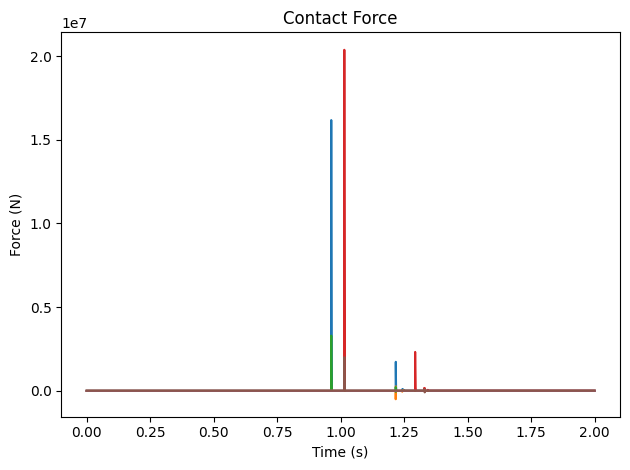

In [11]:
fig = plt.figure()
plt.plot(t, force1)
plt.plot(t, force2)
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Contact Force')